# Trabalho Final

### Projete e treine uma rede neural para efetuar um cálculo (soma, subtração, ou multiplicação) usando duas imagens do MNIST. 

Exemplos: 
* (Imagem do dígito 3) + (Imagem do dígito 5) = 8
* (Imagem do dígito 2) - (Imagem do dígito 1) = 1
* (Imagem do dígito 9) x (Imagem do dígito 5) = 45
* (Imagem do dígito 1) + (Imagem do dígito 2) = 3

Dicas: 
* A rede receberá duas entradas: um tensor contento duas imagens, e outro tensor contendo um inteiro que representa a operação
* A saída sempre será um número inteiro 
* Os índices das operações são os seguintes: 0 - Soma, 1 - Subtração, 2 - Multiplicação
* Pense em uma forma de transformar os inteiros que representam as operações em vetores

In [1]:
%matplotlib inline

### Atenção: Rode esta linha apenas se estiver usando o Google Colab

In [ ]:
# http://pytorch.org/
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
import torch

In [2]:
import torch
from torch import nn
from torch import optim
import torchvision
from matplotlib import pyplot as plt
from torchvision import transforms
from torchvision import datasets

### O código das célula abaixo contém funções para efetuar a carga dos dados, treinamento e teste dos modelos

In [4]:
def train(
        model,
        train_loader,
        test_loader,
        device,
        lr,
        nb_epochs=3,
        log_interval=100,
    ):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss().to(device)

    print('\n* * * Evaluating * * *')
    acc = test(model, device, criterion, test_loader)
    
    for epoch in range(1, nb_epochs + 1):
        print('\n* * * Training * * *')
        train_epoch(
            model=model, 
            device=device, 
            train_loader=train_loader, 
            optimizer=optimizer, 
            criterion=criterion, 
            epoch=epoch, 
            log_interval=log_interval
        )
        print('\n* * * Evaluating * * *')
        acc = test(model, device, criterion, test_loader)
    
    return acc



In [5]:
def get_loaders(batch_size):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])

    train_loader = torch.utils.data.DataLoader(
        dataset=datasets.MNIST(
            root='../data', 
            train=True, 
            download=True,
            transform=transform,
        ),
        batch_size=batch_size, 
        shuffle=True,
        collate_fn=collate_fn
    )

    test_loader = torch.utils.data.DataLoader(
        dataset=datasets.MNIST(
            root='../data', 
            train=False, 
            download=True,
            transform=transform,
        ),
        batch_size=batch_size, 
        shuffle=True,
        collate_fn=collate_fn
    )
    return train_loader, test_loader



In [6]:
from collections import OrderedDict
operators = OrderedDict({
    '': -1,
    '+': 0,
    '-': 1,
    '*': 2,
})

n_operators = len(operators)-1
operators_i2o = {v: k for k, v in operators.items()}

In [7]:
def collate_fn(data):
    digits, labels = zip(*data)
    digits = torch.stack(digits, 0).float()
    labels = torch.stack(labels, 0)
    
    digits_idxs_mask = sample_digits(digits, 2)
    
    new_data = digits[digits_idxs_mask]
    digit_targets = labels[digits_idxs_mask]
    
    sampled_ops = sample_operators(len(new_data), 1, total_ops=3)
    target, equation_str = make_ground_truth(digit_targets, sampled_ops)

    return new_data, target, equation_str, sampled_ops

In [8]:
def sample_digits(data, n_digits):
    N = data.shape[0]
    clear_diag = (1-torch.eye(N, N))
    prob_matrix = clear_diag * torch.empty(N, N).uniform_(0, 1)
    return torch.multinomial(prob_matrix, n_digits)

In [9]:
def sample_operators(n_samples, sample_n_ops, total_ops=3):
    return torch.multinomial(torch.empty(n_samples, total_ops).uniform_(0, 1), sample_n_ops)

In [10]:
def make_ground_truth(digit_targets, sampled_ops):
    
    result_targets = []
    result_equations = []
    
    for ds, op in zip(digit_targets, sampled_ops):
        op = torch.cat([op, -torch.ones(1).long()])
        
        equation = ''.join(['{}{}'.format(d, operators_i2o[o.item()]) for d, o in zip(ds, op)])
        result_equations.append(equation)
        result = eval(equation)
        result_targets.append(result)
    
    return torch.LongTensor(result_targets)+9, result_equations
    

In [11]:
def plot_instances(new_data, operators, pred_scores, nb_inst=5):
    fig, axes = plt.subplots(nb_inst, 2, )
    for i in range(nb_inst):
        axs = axes[i]
        data = new_data[i]
        ops = operators[i]
        pred = pred_scores[i]
        for digit, ax in zip(data, axs):
            digit = digit.cpu().permute(1, 2, 0).squeeze()        
            ax.imshow(digit, cmap='gray')
            ax.set_xticks([])
            ax.set_yticks([])
        ax.text(-50, 15, operators_i2o[ops[0].item()], fontsize=24)
        ax.text(30, 15, '={}'.format(pred.cpu().numpy()-9), fontsize=24)    
    

In [12]:
def train_epoch(
        model, 
        device, 
        train_loader, 
        optimizer, 
        criterion, 
        epoch, 
        log_interval
    ):
    model.train()
    history = []
    for batch_idx, data in enumerate(train_loader):
        data, target, eq_str, sampled_ops = data
        data = data.to(device)
        target = target.to(device)
        sampled_ops= sampled_ops.to(device)
        
        optimizer.zero_grad()
        output = model(digits=data, ops=sampled_ops)

        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))



In [13]:
def test(
        model, 
        device, 
        criterion, 
        test_loader, 
        plot_images=True
    ):
    model.eval()
    test_loss = 0
    correct = 0
    mse_loss = nn.MSELoss()
    total_mse = 0
    with torch.no_grad():
        for data, target, eq_str, sampled_ops in test_loader:
    
            data = data.to(device)
            target = target.to(device)
            sampled_ops= sampled_ops.to(device)
            
            output = model(digits=data, ops=sampled_ops)
            test_loss += criterion(output, target).item() # sum up batch loss                        
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            
            total_mse += mse_loss(pred.float().squeeze(), target.float()).item()
            correct += pred.eq(target.view_as(pred)).sum().item()
            
        plot_instances(new_data=data, operators=sampled_ops, pred_scores=pred)            
            
        
    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    print('Test set:\nAverage loss: {:.4f}\nAccuracy: {}/{} ({:.2f}%)\nErro Médio: {:.2f}\n'.format(
        test_loss, correct, len(test_loader.dataset),
        accuracy, total_mse))
    return accuracy

### Hyper-parâmetros que você pode definir

In [14]:
batch_size = 16
device_name = 'cpu'
nb_epochs = 10
log_interval = 50
lr = 1e-3

In [15]:
device = torch.device(device_name)

### Conferência dos dados

#### Entrada da rede: digits=(batch, num_digitos, canais, altura, largura), ops=(batch, operador) 
* num_digitos=2
* canais=1
* altura
* largura=28

### Operadores 
* -1) Nenhum
* 0) Soma (`+`)
* 1) Subtração (`-`)
* 2) Multiplicação (`*`)

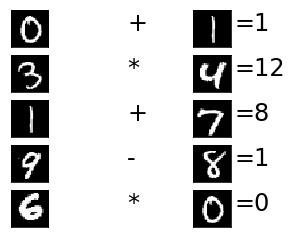

In [16]:
train_loader, test_loader = get_loaders(batch_size=batch_size)
digit_images, eq_target, eq_str, operator_ids = next(iter(train_loader))

plot_instances(digit_images, operator_ids, eq_target)

In [17]:
print('Dados de entrada na rede:')
print('Imagens   : ', digit_images.shape)
print('Operadores: ', operator_ids.shape)
print('... Ex Ops: ', operator_ids[:5].numpy().tolist(), operators)
print('Classes   : ', eq_target.shape)
print('... Ex Cls: ', eq_target[:5].numpy().tolist())

Dados de entrada na rede:
Imagens   :  torch.Size([16, 2, 1, 28, 28])
Operadores:  torch.Size([16, 1])
... Ex Ops:  [[0], [2], [0], [1], [2]] OrderedDict([('', -1), ('*', 2), ('-', 1), ('+', 0)])
Classes   :  torch.Size([16])
... Ex Cls:  [10, 21, 17, 10, 9]


## Seu trabalho começa aqui

### 1) Implemente uma rede capaz de compreender o conteúdo das imagens do MNIST.

In [18]:
class DigitsConvNet(nn.Module):
    def __init__(self):
        super(DigitsConvNet, self).__init__()
        self.conv_1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.conv_2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.fc = nn.Linear(in_features=3136, out_features=10)
        
        self.pool = nn.MaxPool2d(kernel_size=2)
        self.relu = nn.ReLU(inplace=True)
        
    def forward(self, x):
        x = self.conv_1(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.conv_2(x)
        x = self.relu(x)
        x = self.pool(x)
        x = x.view(x.shape[0], 64*7*7) # Ou x = x.view(x.shape[0], -1)
        x = self.fc(x)
        return x

In [19]:
net = DigitsConvNet()

print(net)
pred = net(torch.zeros(5, 1, 28, 28))
print(pred.shape)

assert pred.shape[0] == 5 and len(pred.shape) == 2
print('Passed! Go to the next step.')

DigitsConvNet(
  (conv_1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc): Linear(in_features=3136, out_features=10, bias=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU(inplace)
)
torch.Size([5, 10])
Passed! Go to the next step.


### 2) Implemente uma rede neural capaz de resolver uma operação matemática entre duas imagens do MNIST. 
* **DICA**: Utilize a DigitsConvNet como um módulo dentro da EquationNet para extrair vetores de características de todas as imagens.

In [37]:
class EquationNet(nn.Module):
    def __init__(self):
        super(EquationNet, self).__init__()
        self.digitsConvNet = DigitsConvNet()
        self.conv = nn.Conv1d(in_channels=10, out_channels=192, kernel_size=3)
        self.relu = nn.ReLU(inplace=True)
        self.drop = nn.Dropout(p=0.1)
        self.fcops = nn.Linear(in_features=4, out_features=10)
        self.fc0 = nn.Linear(in_features=192, out_features=128)
        # self.fc1 = nn.Linear(in_features=46, out_features=192)
        self.fc2 = nn.Linear(in_features=128, out_features=91)
        
    def forward(self, digits, ops):
        batch = len(ops)
        a = torch.split(digits,1,dim=1)
        #print(a[0].shape)
        #print(a[1].shape)
        xa = a[0].squeeze(1)
        xb = a[1].squeeze(1)
        x = self.digitsConvNet(xa)
        y = self.digitsConvNet(xb)
        #print(x.shape)
        #print(y.shape)
        #print(ops.dtype)
        #ops = ops.to(torch.int32)
        opshot = torch.FloatTensor(batch, 4)
        opshot.zero_()
        #print(opshot.shape)
        opshot.scatter_(1, ops, 1)
        #print(opshot)
        opsf = self.fcops(opshot)
        opsf.to(torch.float32)
        features = torch.cat((x,y,opsf),dim=1)
        #print(features.shape)
        features = torch.reshape(features,(batch,10,3))
        #features = features.permute(0,2,1)
        #print(features.shape)
        result = self.conv(features)
        self.relu(result)
        
        #print(result.shape)
        result = result.squeeze(2)
        #print(result.shape)
        result = self.fc0(result)
        self.relu(result)
        result = self.drop(result)
        #result = self.fc1(result)
        #self.relu(result)
        result = self.fc2(result)
        return result

In [38]:
model = EquationNet().to(device)
print(model)
model.fc2.weight[28].data.zero_()
model.fc2.weight[29].data.zero_()
model.fc2.weight[31].data.zero_()
model.fc2.weight[32].data.zero_()
model.fc2.weight[35].data.zero_()
model.fc2.weight[38].data.zero_()
model.fc2.weight[39].data.zero_()
model.fc2.weight[40].data.zero_()
model.fc2.weight[42].data.zero_()
model.fc2.weight[43].data.zero_()
model.fc2.weight[46].data.zero_()
model.fc2.weight[47].data.zero_()
model.fc2.weight[48].data.zero_()
model.fc2.weight[49].data.zero_()
model.fc2.weight[50].data.zero_()
model.fc2.weight[52].data.zero_()
model.fc2.weight[53].data.zero_()
model.fc2.weight[55].data.zero_()
model.fc2.weight[56].data.zero_()
model.fc2.weight[59].data.zero_()
model.fc2.weight[60].data.zero_()
model.fc2.weight[61].data.zero_()
model.fc2.weight[62].data.zero_()
model.fc2.weight[64].data.zero_()
model.fc2.weight[66].data.zero_()
model.fc2.weight[67].data.zero_()
model.fc2.weight[68].data.zero_()
model.fc2.weight[69].data.zero_()
model.fc2.weight[70].data.zero_()
model.fc2.weight[71].data.zero_()
model.fc2.weight[74].data.zero_()
model.fc2.weight[75].data.zero_()
model.fc2.weight[76].data.zero_()
model.fc2.weight[77].data.zero_()
model.fc2.weight[78].data.zero_()
model.fc2.weight[79].data.zero_()
model.fc2.weight[80].data.zero_()
model.fc2.weight[82].data.zero_()
model.fc2.weight[83].data.zero_()
model.fc2.weight[84].data.zero_()
model.fc2.weight[85].data.zero_()
model.fc2.weight[86].data.zero_()
model.fc2.weight[87].data.zero_()
model.fc2.weight[88].data.zero_()
# print(model.fc2.weight[89])
model.fc2.weight[89].data.zero_()
# print(model.fc2.weight[89])

model.fc2.bias[28].data.zero_()
model.fc2.bias[29].data.zero_()
model.fc2.bias[31].data.zero_()
model.fc2.bias[32].data.zero_()
model.fc2.bias[35].data.zero_()
model.fc2.bias[38].data.zero_()
model.fc2.bias[39].data.zero_()
model.fc2.bias[40].data.zero_()
model.fc2.bias[42].data.zero_()
model.fc2.bias[43].data.zero_()
model.fc2.bias[46].data.zero_()
model.fc2.bias[47].data.zero_()
model.fc2.bias[48].data.zero_()
model.fc2.bias[49].data.zero_()
model.fc2.bias[50].data.zero_()
model.fc2.bias[52].data.zero_()
model.fc2.bias[53].data.zero_()
model.fc2.bias[55].data.zero_()
model.fc2.bias[56].data.zero_()
model.fc2.bias[59].data.zero_()
model.fc2.bias[60].data.zero_()
model.fc2.bias[61].data.zero_()
model.fc2.bias[62].data.zero_()
model.fc2.bias[64].data.zero_()
model.fc2.bias[66].data.zero_()
model.fc2.bias[67].data.zero_()
model.fc2.bias[68].data.zero_()
model.fc2.bias[69].data.zero_()
model.fc2.bias[70].data.zero_()
model.fc2.bias[71].data.zero_()
model.fc2.bias[74].data.zero_()
model.fc2.bias[75].data.zero_()
model.fc2.bias[76].data.zero_()
model.fc2.bias[77].data.zero_()
model.fc2.bias[78].data.zero_()
model.fc2.bias[79].data.zero_()
model.fc2.bias[80].data.zero_()
model.fc2.bias[82].data.zero_()
model.fc2.bias[83].data.zero_()
model.fc2.bias[84].data.zero_()
model.fc2.bias[85].data.zero_()
model.fc2.bias[86].data.zero_()
model.fc2.bias[87].data.zero_()
model.fc2.bias[88].data.zero_()
# print(model.fc2.weight[89])
model.fc2.bias[89].data.zero_()

# Init dummy data
dummy_digits = torch.zeros(5, 2, 1, 28, 28).to(device)
dummy_operators = torch.ones(5, 1).long().to(device)
# Forward 
dummy_pred = model(digits=dummy_digits, ops=dummy_operators)

EquationNet(
  (digitsConvNet): DigitsConvNet(
    (conv_1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv_2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fc): Linear(in_features=3136, out_features=10, bias=True)
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (relu): ReLU(inplace)
  )
  (conv): Conv1d(10, 192, kernel_size=(3,), stride=(1,))
  (relu): ReLU(inplace)
  (drop): Dropout(p=0.1)
  (fcops): Linear(in_features=4, out_features=10, bias=True)
  (fc0): Linear(in_features=192, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=91, bias=True)
)


In [39]:
# Check network's input and output
assert dummy_pred.shape == (5, 91), 'Expected: (5, 10), Found: {}'.format(dummy_pred.shape)
print('Passed')

Passed


### 3) Treine seu modelo por algumas épocas e reporte o resultado. 
* **Dica**: com uma rede leve, em 4 épocas, é possível alcançar acurácia de >=95%, e um erro médio <=1500. 


* * * Evaluating * * *
Test set:
Average loss: 0.2821
Accuracy: 69/10000 (0.69%)
Erro Médio: 1053466.12


* * * Training * * *
Train Epoch: 1 [0/60000 (0%)]	Loss: 4.489268
Train Epoch: 1 [800/60000 (1%)]	Loss: 3.528556
Train Epoch: 1 [1600/60000 (3%)]	Loss: 3.458616
Train Epoch: 1 [2400/60000 (4%)]	Loss: 3.520885
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.966642
Train Epoch: 1 [4000/60000 (7%)]	Loss: 3.236233
Train Epoch: 1 [4800/60000 (8%)]	Loss: 2.579324
Train Epoch: 1 [5600/60000 (9%)]	Loss: 2.841246
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.310427
Train Epoch: 1 [7200/60000 (12%)]	Loss: 2.462815
Train Epoch: 1 [8000/60000 (13%)]	Loss: 2.355304
Train Epoch: 1 [8800/60000 (15%)]	Loss: 2.575185
Train Epoch: 1 [9600/60000 (16%)]	Loss: 3.040874
Train Epoch: 1 [10400/60000 (17%)]	Loss: 2.140295
Train Epoch: 1 [11200/60000 (19%)]	Loss: 2.455331
Train Epoch: 1 [12000/60000 (20%)]	Loss: 2.192343
Train Epoch: 1 [12800/60000 (21%)]	Loss: 2.458537
Train Epoch: 1 [13600/60000 (23%)]	Loss: 1.8410

Train Epoch: 3 [6400/60000 (11%)]	Loss: 0.046107
Train Epoch: 3 [7200/60000 (12%)]	Loss: 0.259576
Train Epoch: 3 [8000/60000 (13%)]	Loss: 0.662175
Train Epoch: 3 [8800/60000 (15%)]	Loss: 0.016958
Train Epoch: 3 [9600/60000 (16%)]	Loss: 0.046625
Train Epoch: 3 [10400/60000 (17%)]	Loss: 0.107675
Train Epoch: 3 [11200/60000 (19%)]	Loss: 0.279954
Train Epoch: 3 [12000/60000 (20%)]	Loss: 0.341929
Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.222699
Train Epoch: 3 [13600/60000 (23%)]	Loss: 0.063215
Train Epoch: 3 [14400/60000 (24%)]	Loss: 0.235923
Train Epoch: 3 [15200/60000 (25%)]	Loss: 0.022528
Train Epoch: 3 [16000/60000 (27%)]	Loss: 0.313101
Train Epoch: 3 [16800/60000 (28%)]	Loss: 0.185839
Train Epoch: 3 [17600/60000 (29%)]	Loss: 0.004085
Train Epoch: 3 [18400/60000 (31%)]	Loss: 0.399665
Train Epoch: 3 [19200/60000 (32%)]	Loss: 0.108965
Train Epoch: 3 [20000/60000 (33%)]	Loss: 0.091717
Train Epoch: 3 [20800/60000 (35%)]	Loss: 0.100210
Train Epoch: 3 [21600/60000 (36%)]	Loss: 0.169711
Train

Train Epoch: 5 [14400/60000 (24%)]	Loss: 0.091458
Train Epoch: 5 [15200/60000 (25%)]	Loss: 0.887386
Train Epoch: 5 [16000/60000 (27%)]	Loss: 0.696004
Train Epoch: 5 [16800/60000 (28%)]	Loss: 0.354953
Train Epoch: 5 [17600/60000 (29%)]	Loss: 0.133408
Train Epoch: 5 [18400/60000 (31%)]	Loss: 0.001709
Train Epoch: 5 [19200/60000 (32%)]	Loss: 0.026026
Train Epoch: 5 [20000/60000 (33%)]	Loss: 0.001745
Train Epoch: 5 [20800/60000 (35%)]	Loss: 0.068136
Train Epoch: 5 [21600/60000 (36%)]	Loss: 0.120167
Train Epoch: 5 [22400/60000 (37%)]	Loss: 0.205563
Train Epoch: 5 [23200/60000 (39%)]	Loss: 0.263713
Train Epoch: 5 [24000/60000 (40%)]	Loss: 0.014607
Train Epoch: 5 [24800/60000 (41%)]	Loss: 0.142186
Train Epoch: 5 [25600/60000 (43%)]	Loss: 0.063767
Train Epoch: 5 [26400/60000 (44%)]	Loss: 0.122271
Train Epoch: 5 [27200/60000 (45%)]	Loss: 0.002027
Train Epoch: 5 [28000/60000 (47%)]	Loss: 0.136018
Train Epoch: 5 [28800/60000 (48%)]	Loss: 0.416068
Train Epoch: 5 [29600/60000 (49%)]	Loss: 0.010210


Train Epoch: 7 [22400/60000 (37%)]	Loss: 0.065810
Train Epoch: 7 [23200/60000 (39%)]	Loss: 0.177920
Train Epoch: 7 [24000/60000 (40%)]	Loss: 0.016287
Train Epoch: 7 [24800/60000 (41%)]	Loss: 0.743958
Train Epoch: 7 [25600/60000 (43%)]	Loss: 0.008297
Train Epoch: 7 [26400/60000 (44%)]	Loss: 0.278340
Train Epoch: 7 [27200/60000 (45%)]	Loss: 0.094629
Train Epoch: 7 [28000/60000 (47%)]	Loss: 0.046825
Train Epoch: 7 [28800/60000 (48%)]	Loss: 0.268565
Train Epoch: 7 [29600/60000 (49%)]	Loss: 0.652244
Train Epoch: 7 [30400/60000 (51%)]	Loss: 0.000631
Train Epoch: 7 [31200/60000 (52%)]	Loss: 0.254550
Train Epoch: 7 [32000/60000 (53%)]	Loss: 0.000597
Train Epoch: 7 [32800/60000 (55%)]	Loss: 0.008066
Train Epoch: 7 [33600/60000 (56%)]	Loss: 0.085141
Train Epoch: 7 [34400/60000 (57%)]	Loss: 0.057267
Train Epoch: 7 [35200/60000 (59%)]	Loss: 0.074217
Train Epoch: 7 [36000/60000 (60%)]	Loss: 0.160980
Train Epoch: 7 [36800/60000 (61%)]	Loss: 0.012105
Train Epoch: 7 [37600/60000 (63%)]	Loss: 0.200284


Train Epoch: 9 [30400/60000 (51%)]	Loss: 0.000571
Train Epoch: 9 [31200/60000 (52%)]	Loss: 0.003152
Train Epoch: 9 [32000/60000 (53%)]	Loss: 0.307339
Train Epoch: 9 [32800/60000 (55%)]	Loss: 0.038780
Train Epoch: 9 [33600/60000 (56%)]	Loss: 0.090578
Train Epoch: 9 [34400/60000 (57%)]	Loss: 0.000730
Train Epoch: 9 [35200/60000 (59%)]	Loss: 0.005208
Train Epoch: 9 [36000/60000 (60%)]	Loss: 0.003336
Train Epoch: 9 [36800/60000 (61%)]	Loss: 0.107814
Train Epoch: 9 [37600/60000 (63%)]	Loss: 0.001600
Train Epoch: 9 [38400/60000 (64%)]	Loss: 0.210625
Train Epoch: 9 [39200/60000 (65%)]	Loss: 2.627684
Train Epoch: 9 [40000/60000 (67%)]	Loss: 0.046867
Train Epoch: 9 [40800/60000 (68%)]	Loss: 0.011603
Train Epoch: 9 [41600/60000 (69%)]	Loss: 0.000251
Train Epoch: 9 [42400/60000 (71%)]	Loss: 0.089258
Train Epoch: 9 [43200/60000 (72%)]	Loss: 0.002042
Train Epoch: 9 [44000/60000 (73%)]	Loss: 0.020213
Train Epoch: 9 [44800/60000 (75%)]	Loss: 0.025545
Train Epoch: 9 [45600/60000 (76%)]	Loss: 0.003910


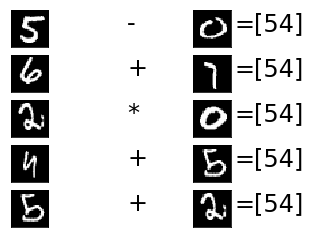

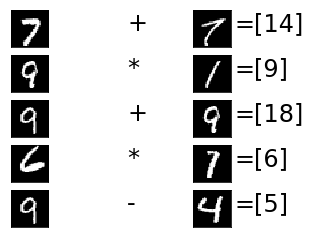

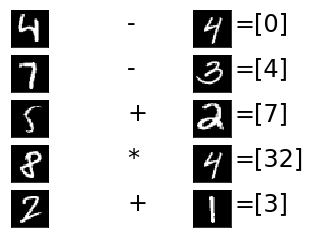

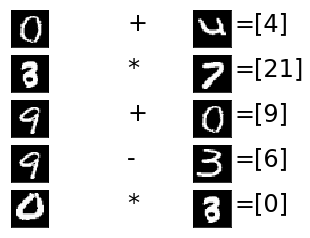

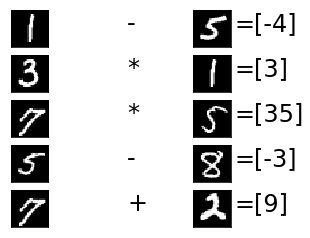

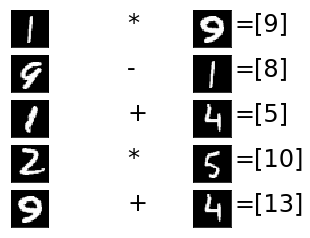

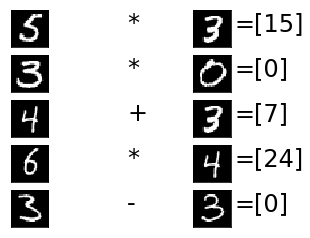

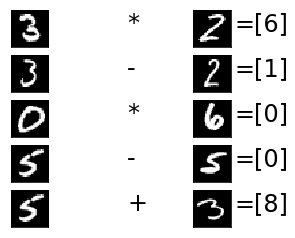

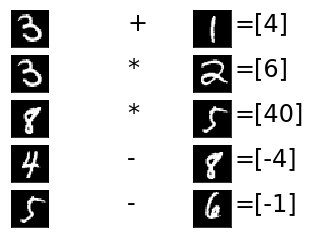

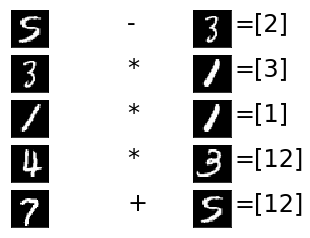

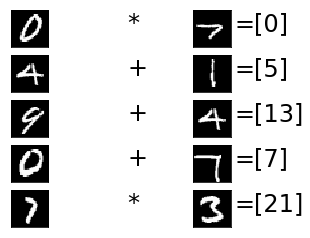

In [36]:
acc = train(model, train_loader, test_loader, device, lr, nb_epochs, log_interval)
print('Final acc: {:.2f}%'.format(acc))